## Import the required libraries

In [181]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import setuptools.dist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


In [182]:
demandDataPath = "/Users/jasmine/Desktop/UA/Stats 1R Take_Home_demand_data.csv"
predictDataPath = "/Users/jasmine/Desktop/UA/Stats 1R Take_Home_predicted_fare.csv"

demandData = pd.read_csv(demandDataPath)
predictData = pd.read_csv(predictDataPath)


# Preprocess the data (assuming 'fare' and 'bookings' are columns in demandData)
demandData = demandData.dropna(subset=['fare', 'bookings'])
predictData = predictData.dropna(subset=['Fares ($)'])


print(demandData.head())

     fare  bookings seasonindex
0  143.88       3.0    Off-Peak
1  167.78       2.0        Peak
2  195.21       0.0        Peak
3  198.84       4.0        Peak
4  134.94       3.0    Off-Peak


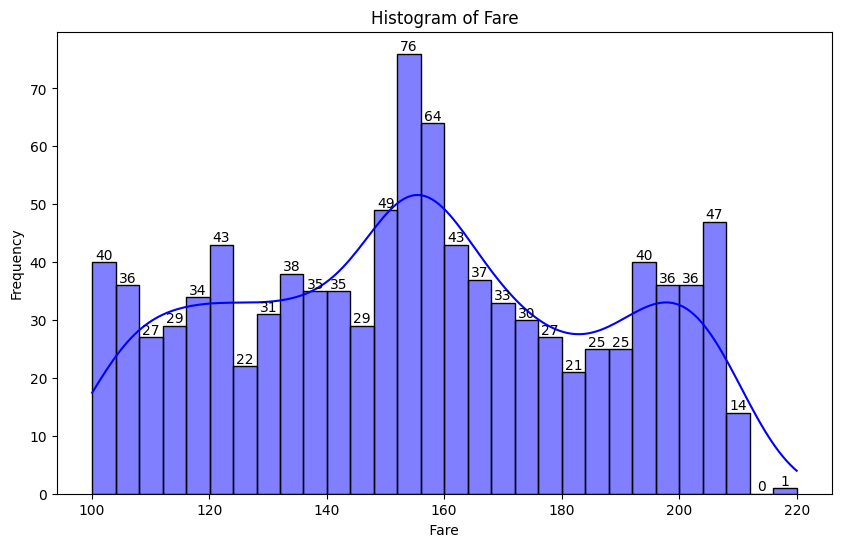

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression


# Plot histogram for 'reciprocal_fare' using Seaborn
plt.figure(figsize=(10, 6))
ax1 = sns.histplot(demandData['fare'], bins=30, color='blue', kde=True)
plt.xlabel(' Fare ')
plt.ylabel('Frequency')
plt.title('Histogram of Fare')

# Add count numbers on each bar for 'reciprocal_fare'
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

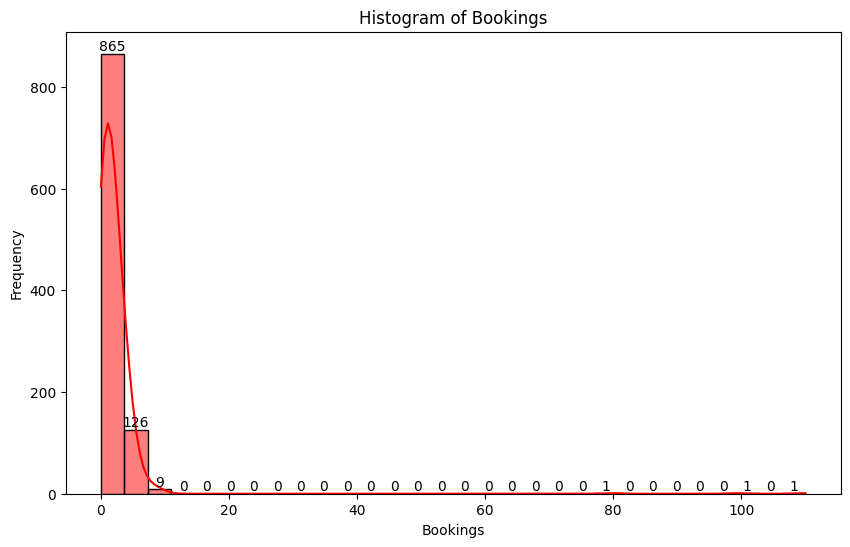

In [184]:
# Plot histogram for 'bookings' using Seaborn
plt.figure(figsize=(10, 6))
ax2 = sns.histplot(demandData['bookings'], bins=30, color='red', kde=True)
plt.xlabel('Bookings')
plt.ylabel('Frequency')
plt.title('Histogram of Bookings')

# Add count numbers on each bar for 'bookings'
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

In [185]:
# Remove outliers using the IQR method
Q1 = demandData['bookings'].quantile(0.25)
Q3 = demandData['bookings'].quantile(0.75)
IQR = Q3 - Q1
filter = (demandData['bookings'] >= Q1 - 1.5 * IQR) & (demandData['bookings'] <= Q3 + 1.5 * IQR)
demandData = demandData.loc[filter]

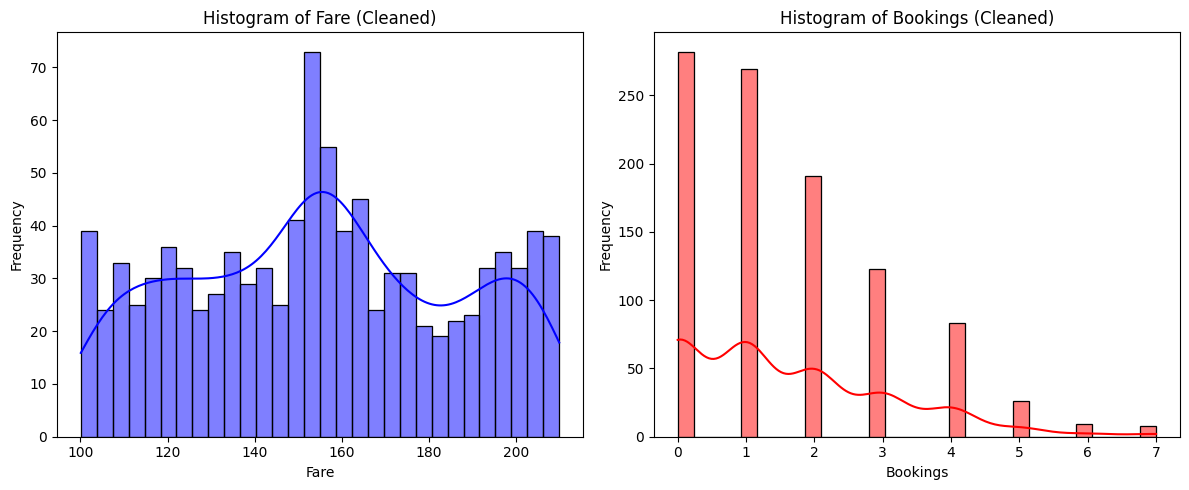

In [186]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(demandData['fare'], bins=30, color='blue', kde=True)
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Histogram of Fare (Cleaned)')

plt.subplot(1, 2, 2)
sns.histplot(demandData['bookings'], bins=30, color='red', kde=True)
plt.xlabel('Bookings')
plt.ylabel('Frequency')
plt.title('Histogram of Bookings (Cleaned)')

plt.tight_layout()
plt.show()

## Linear Model

In [187]:
# Separate the data into "Off-Peak" and "Peak"
off_peak_data = demandData[demandData['seasonindex'] == 'Off-Peak']
peak_data = demandData[demandData['seasonindex'] == 'Peak']

# Feature selection
X_off_peak = off_peak_data[['fare']]
y_off_peak = off_peak_data['bookings']
X_peak = peak_data[['fare']]
y_peak = peak_data['bookings']

# Train the models
model_off_peak = LinearRegression()
model_off_peak.fit(X_off_peak, y_off_peak)

model_peak = LinearRegression()
model_peak.fit(X_peak, y_peak)

# Get the coefficients and intercepts for the off-peak model
coef_off_peak = model_off_peak.coef_[0]
intercept_off_peak = model_off_peak.intercept_

# Get the coefficients and intercepts for the peak model
coef_peak = model_peak.coef_[0]
intercept_peak = model_peak.intercept_

# Print the linear equations
print(f'Off-Peak Model: bookings = {coef_off_peak} * fare + {intercept_off_peak}')
print(f'Peak Model: bookings = {coef_peak} * fare + {intercept_peak}')


# Calculate R^2 for both models
r2_off_peak = model_off_peak.score(X_off_peak, y_off_peak)
r2_peak = model_peak.score(X_peak, y_peak)

print(f'R^2 for Off-Peak Model: {r2_off_peak}')
print(f'R^2 for Peak Model: {r2_peak}')


Off-Peak Model: bookings = -0.015864051923704884 * fare + 3.3791320099290063
Peak Model: bookings = -0.025809503747832304 * fare + 6.551925278933437
R^2 for Off-Peak Model: 0.04244650475611633
R^2 for Peak Model: 0.0851577460234264


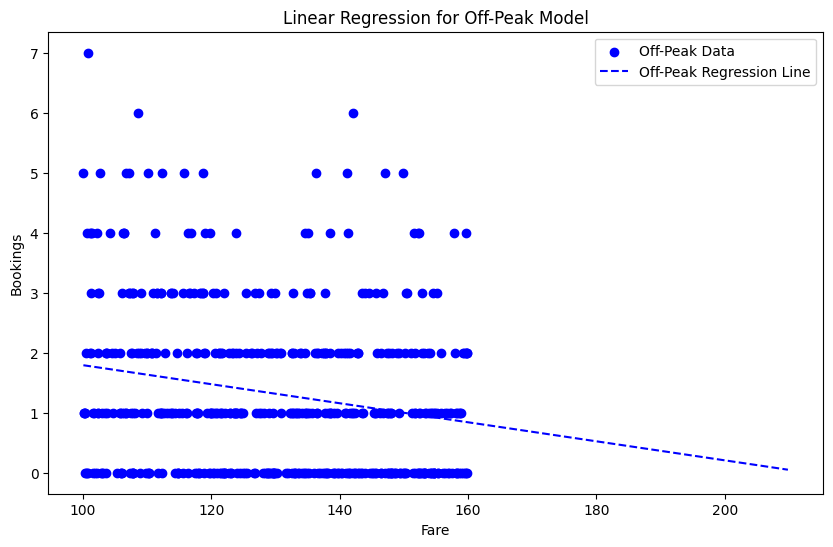

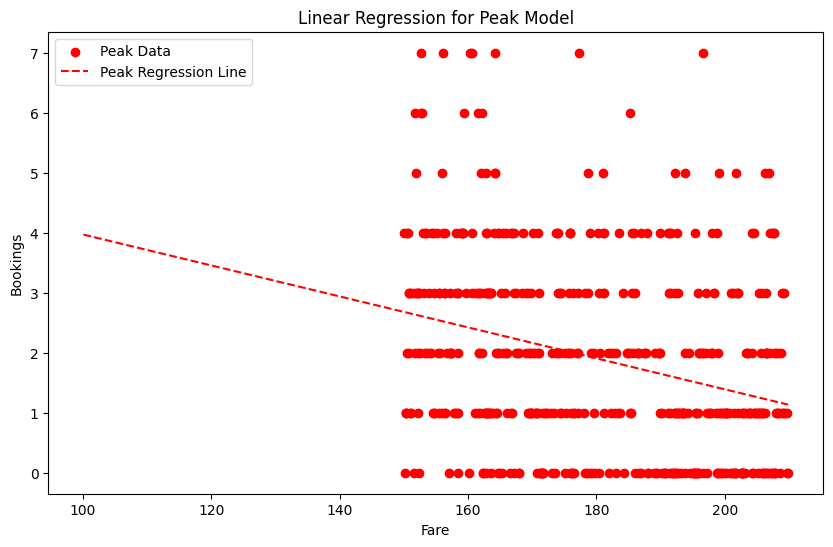

In [188]:
# Create a range of reciprocal fare values for plotting the regression lines
fare_values = np.linspace(demandData['fare'].min(), demandData['fare'].max(), 100)

# Calculate the predicted bookings for the regression lines
bookings_off_peak = coef_off_peak * fare_values + intercept_off_peak
bookings_peak = coef_peak * fare_values + intercept_peak

# Plot the original data points and regression line for Off-Peak
plt.figure(figsize=(10, 6))
plt.scatter(off_peak_data['fare'], off_peak_data['bookings'], color='blue', label='Off-Peak Data')
plt.plot(fare_values, bookings_off_peak, color='blue', linestyle='--', label='Off-Peak Regression Line')
plt.xlabel('Fare')
plt.ylabel('Bookings')
plt.title('Linear Regression for Off-Peak Model')
plt.legend()
plt.show()

# Plot the original data points and regression line for Peak
plt.figure(figsize=(10, 6))
plt.scatter(peak_data['fare'], peak_data['bookings'], color='red', label='Peak Data')
plt.plot(fare_values, bookings_peak, color='red', linestyle='--', label='Peak Regression Line')
plt.xlabel('Fare')
plt.ylabel('Bookings')
plt.title('Linear Regression for Peak Model')
plt.legend()
plt.show()

In [189]:
# Rename the column to match the feature name used during training
predictData.rename(columns={'Fares ($)': 'fare'}, inplace=True)

# Ensure the data only has the 'fare' column
predictData = predictData[['fare']]

# Make predictions using the previously trained models
pred_off_peak = model_off_peak.predict(predictData)
pred_peak = model_peak.predict(predictData)

# Add predictions to the DataFrame
predictData['predicted_bookings_off_peak'] = pred_off_peak
predictData['predicted_bookings_peak'] = pred_peak

# Output the results
print(predictData)

    fare  predicted_bookings_off_peak  predicted_bookings_peak
0    220                    -0.110959                 0.873834
1    230                    -0.269600                 0.615739
2    240                    -0.428240                 0.357644
3    250                    -0.586881                 0.099549
4    260                    -0.745521                -0.158546
5    270                    -0.904162                -0.416641
6    280                    -1.062803                -0.674736
7    290                    -1.221443                -0.932831
8    300                    -1.380084                -1.190926
9    310                    -1.538724                -1.449021
10   320                    -1.697365                -1.707116
11   330                    -1.856005                -1.965211
12   340                    -2.014646                -2.223306
13   350                    -2.173286                -2.481401
14   360                    -2.331927                -2

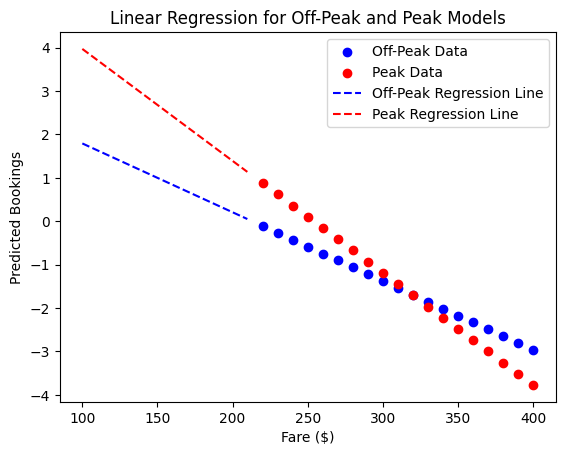

In [191]:
# Plot the original data points
plt.scatter(predictData['fare'], predictData['predicted_bookings_off_peak'], color='blue', label='Off-Peak Data')
plt.scatter(predictData['fare'], predictData['predicted_bookings_peak'], color='red', label='Peak Data')

# Plot the regression lines
plt.plot(fare_values, bookings_off_peak, color='blue', linestyle='--', label='Off-Peak Regression Line')
plt.plot(fare_values, bookings_peak, color='red', linestyle='--', label='Peak Regression Line')

# Add labels and legend
plt.xlabel('Fare ($)')
plt.ylabel('Predicted Bookings')
plt.title('Linear Regression for Off-Peak and Peak Models')
plt.legend()

## Power Relationship

In [234]:
demandData['log_fare'] = np.log(demandData['fare'])


In [235]:
# Separate the data into "Off-Peak" and "Peak"
off_peak_data = demandData[demandData['seasonindex'] == 'Off-Peak']
peak_data = demandData[demandData['seasonindex'] == 'Peak']

# Feature selection
X_off_peak = off_peak_data[['log_fare']]
y_off_peak = off_peak_data['bookings']
X_peak = peak_data[['log_fare']]
y_peak = peak_data['bookings']

In [236]:
# Train the models
model_off_peak = LinearRegression()
model_off_peak.fit(X_off_peak, y_off_peak)

model_peak = LinearRegression()
model_peak.fit(X_peak, y_peak)

# Get the coefficients and intercepts for the off-peak model
beta_off_peak = model_off_peak.coef_[0]
log_alpha_off_peak = model_off_peak.intercept_
alpha_off_peak = np.exp(log_alpha_off_peak)

# Get the coefficients and intercepts for the peak model
beta_peak = model_peak.coef_[0]
log_alpha_peak = model_peak.intercept_
alpha_peak = np.exp(log_alpha_peak)

# Print the power relationship parameters
print(f'Off-Peak Model: Bookings = {alpha_off_peak} * Fare^{beta_off_peak}')
print(f'Peak Model: Bookings = {alpha_peak} * Fare^{beta_peak}')
r2_off_peak = model_off_peak.score(X_off_peak, y_off_peak)
r2_peak = model_peak.score(X_peak, y_peak)

print(f'R^2 for Off-Peak Model: {r2_off_peak}')
print(f'R^2 for Peak Model: {r2_peak}')

Off-Peak Model: Bookings = 67515.30940160035 * Fare^-2.010680971086545
Peak Model: Bookings = 135886725526.89134 * Fare^-4.569776295762219
R^2 for Off-Peak Model: 0.04362360858594616
R^2 for Peak Model: 0.08593784170269236


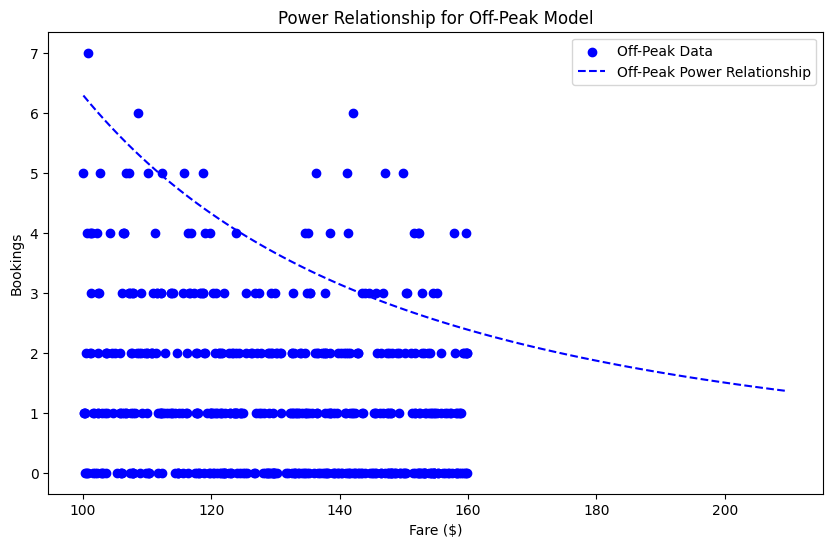

In [205]:
# Create a range of fare values for plotting the power relationship
fare_values = np.linspace(demandData['fare'].min(), demandData['fare'].max(), 100)

# Calculate the predicted bookings for the power relationship
bookings_off_peak = alpha_off_peak * fare_values ** beta_off_peak
# Plot the original data points and power relationship for Off-Peak
plt.figure(figsize=(10, 6))
plt.scatter(off_peak_data['fare'], off_peak_data['bookings'], color='blue', label='Off-Peak Data')
plt.plot(fare_values, bookings_off_peak, color='blue', linestyle='--', label='Off-Peak Power Relationship')
plt.xlabel('Fare ($)')
plt.ylabel('Bookings')
plt.title('Power Relationship for Off-Peak Model')
plt.legend()
plt.show()

In [206]:
bookings_peak = alpha_peak * fare_values ** beta_peak
print(fare_values)    

[100.08       101.18868687 102.29737374 103.40606061 104.51474747
 105.62343434 106.73212121 107.84080808 108.94949495 110.05818182
 111.16686869 112.27555556 113.38424242 114.49292929 115.60161616
 116.71030303 117.8189899  118.92767677 120.03636364 121.14505051
 122.25373737 123.36242424 124.47111111 125.57979798 126.68848485
 127.79717172 128.90585859 130.01454545 131.12323232 132.23191919
 133.34060606 134.44929293 135.5579798  136.66666667 137.77535354
 138.8840404  139.99272727 141.10141414 142.21010101 143.31878788
 144.42747475 145.53616162 146.64484848 147.75353535 148.86222222
 149.97090909 151.07959596 152.18828283 153.2969697  154.40565657
 155.51434343 156.6230303  157.73171717 158.84040404 159.94909091
 161.05777778 162.16646465 163.27515152 164.38383838 165.49252525
 166.60121212 167.70989899 168.81858586 169.92727273 171.0359596
 172.14464646 173.25333333 174.3620202  175.47070707 176.57939394
 177.68808081 178.79676768 179.90545455 181.01414141 182.12282828
 183.231515

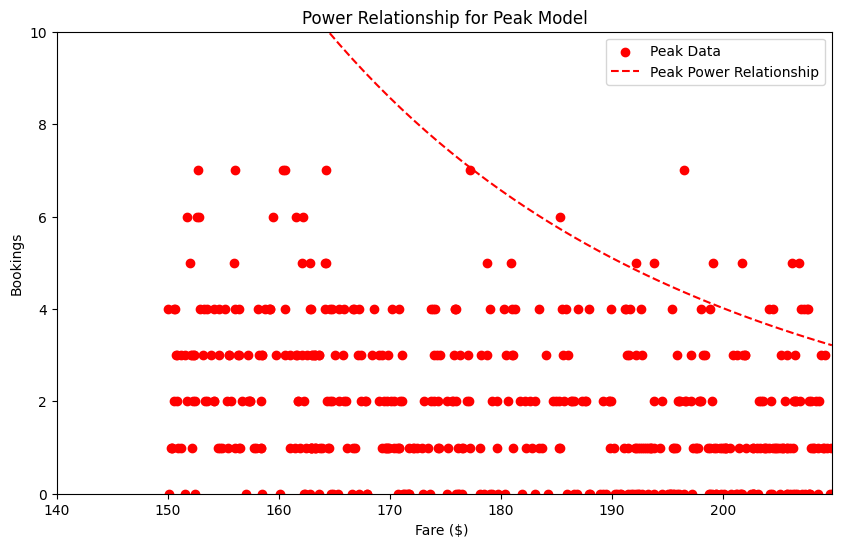

In [207]:
fare_values = np.linspace(demandData['fare'].min(), demandData['fare'].max(), 100)
# Plot the original data points and power relationship for Peak
plt.figure(figsize=(10, 6))
plt.scatter(peak_data['fare'], peak_data['bookings'], color='red', label='Peak Data')
plt.plot(fare_values, bookings_peak, color='red', linestyle='--', label='Peak Power Relationship')

plt.xlabel('Fare ($) ')
plt.ylabel('Bookings')
plt.title('Power Relationship for Peak Model')
plt.legend()
plt.xlim(140, demandData['fare'].max())  # Set x-axis limits
plt.ylim(0, 10)  # Set x-axis limits
plt.show()

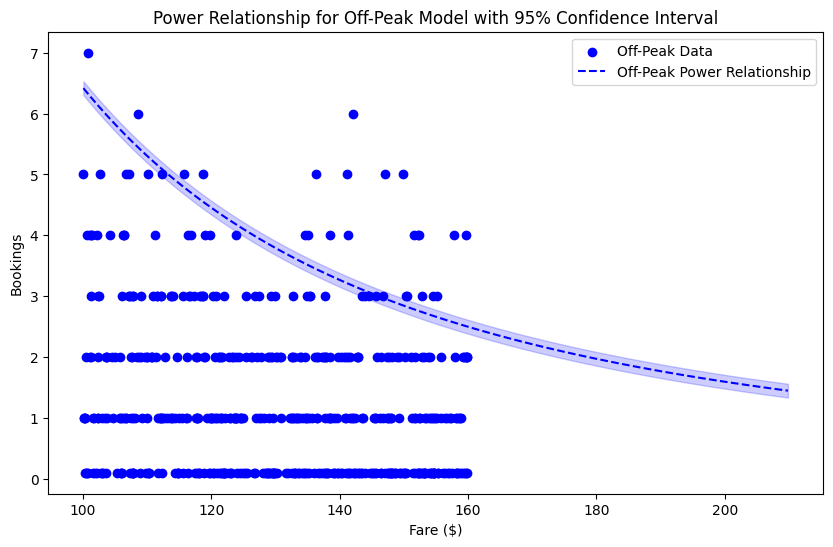

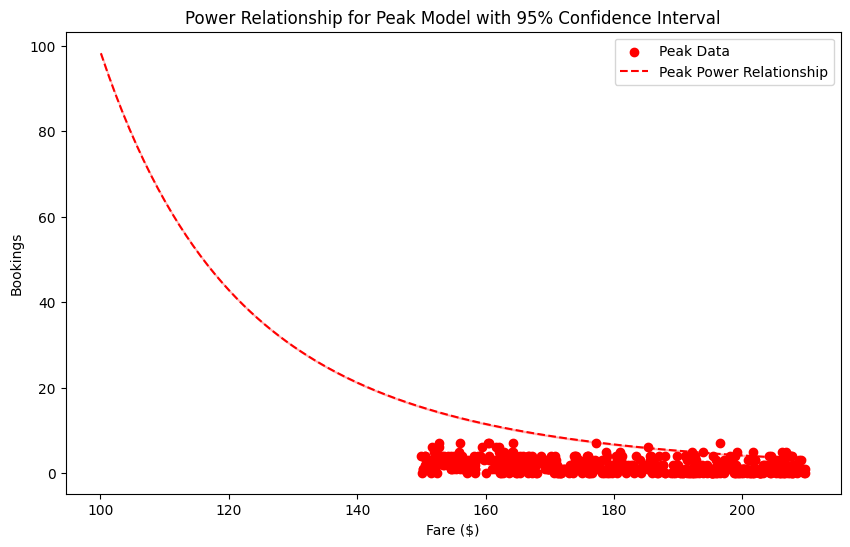

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import t
# Get the coefficients and intercepts for the off-peak model
beta_off_peak = model_off_peak.coef_[0]
log_alpha_off_peak = model_off_peak.intercept_
alpha_off_peak = np.exp(log_alpha_off_peak)

# Get the coefficients and intercepts for the peak model
beta_peak = model_peak.coef_[0]
log_alpha_peak = model_peak.intercept_
alpha_peak = np.exp(log_alpha_peak)

# Create a range of fare values for plotting the power relationship
fare_values = np.linspace(demandData['fare'].min(), demandData['fare'].max(), 100)
log_fare_values = np.log(fare_values)

# Calculate the predicted bookings for the power relationship
bookings_off_peak = alpha_off_peak * fare_values ** beta_off_peak
bookings_peak = alpha_peak * fare_values ** beta_peak
# Calculate the confidence intervals
def get_confidence_intervals(model, X, y, log_fare_values, alpha=0.05):
    predictions = model.predict(X)
    residuals = y - predictions
    mean_x = np.mean(X)
    n = len(X)
    t_value = t.ppf(1 - alpha / 2, df=n - 2)
    s_err = np.sum(np.power(residuals, 2))
    conf = t_value * np.sqrt((s_err / (n - 2)) * (1.0 / n + (np.power(log_fare_values - mean_x, 2) / ((np.sum(np.power(log_fare_values, 2))) - n * (mean_x ** 2)))))
    return conf

conf_off_peak = get_confidence_intervals(model_off_peak, X_off_peak, y_off_peak, log_fare_values)
conf_peak = get_confidence_intervals(model_peak, X_peak, y_peak, log_fare_values)

# Plot the original data points and power relationship for Off-Peak with confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(off_peak_data['fare'], off_peak_data['bookings'], color='blue', label='Off-Peak Data')
plt.plot(fare_values, bookings_off_peak, color='blue', linestyle='--', label='Off-Peak Power Relationship')
plt.fill_between(fare_values, bookings_off_peak - conf_off_peak, bookings_off_peak + conf_off_peak, color='blue', alpha=0.2)
plt.xlabel('Fare ($)')
plt.ylabel('Bookings')
plt.title('Power Relationship for Off-Peak Model with 95% Confidence Interval')
plt.legend()
plt.show()

# Plot the original data points and power relationship for Peak with confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(peak_data['fare'], peak_data['bookings'], color='red', label='Peak Data')
plt.plot(fare_values, bookings_peak, color='red', linestyle='--', label='Peak Power Relationship')
plt.fill_between(fare_values, bookings_peak - conf_peak, bookings_peak + conf_peak, color='red', alpha=0.2)
plt.xlabel('Fare ($)')
plt.ylabel('Bookings')
plt.title('Power Relationship for Peak Model with 95% Confidence Interval')
plt.legend()
plt.show()

In [212]:
# Make predictions using the previously trained models


# Predict bookings using the off-peak model
predictData['predicted_bookings_off_peak_log'] = alpha_off_peak * predictData['fare'] ** beta_off_peak

# Predict bookings using the peak model
predictData['predicted_bookings_peak_log'] = alpha_peak * predictData['fare'] ** beta_peak



# # Output the results
print(predictData[["fare", "predicted_bookings_off_peak_log", "predicted_bookings_peak_log"]])

    fare  predicted_bookings_off_peak_log  predicted_bookings_peak_log
0    220                         1.233157                     2.578506
1    230                         1.124849                     2.096127
2    240                         1.030077                     1.719080
3    250                         0.946685                     1.421316
4    260                         0.872931                     1.183929
5    270                         0.807390                     0.993016
6    280                         0.748894                     0.838232
7    290                         0.696471                     0.711796
8    300                         0.649314                     0.607790
9    310                         0.606743                     0.521677
10   320                         0.568185                     0.449942
11   330                         0.533154                     0.389842
12   340                         0.501234                     0.339219
13   3

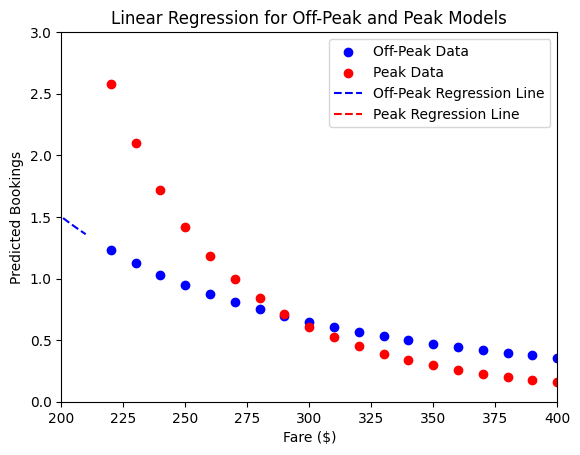

In [199]:
# Plot the original data points
plt.scatter(predictData['fare'], predictData['predicted_bookings_off_peak_log'], color='blue', label='Off-Peak Data')
plt.scatter(predictData['fare'], predictData['predicted_bookings_peak_log'], color='red', label='Peak Data')

# Plot the regression lines
plt.plot(fare_values, bookings_off_peak, color='blue', linestyle='--', label='Off-Peak Regression Line')
plt.plot(fare_values, bookings_peak, color='red', linestyle='--', label='Peak Regression Line')

# Add labels and legend
plt.xlabel('Fare ($)')
plt.ylabel('Predicted Bookings')
plt.title('Linear Regression for Off-Peak and Peak Models')
plt.ylim(0, 3)  # Set y-axis limits
plt.xlim(200, 400)  # Set y-axis limits
plt.legend()

In [213]:
demandData['bookings'] = demandData['bookings'].replace(0, 0.1)
demandData['log_bookings'] = np.log(demandData['bookings'])

In [214]:
# Separate the data into "Off-Peak" and "Peak"
off_peak_data = demandData[demandData['seasonindex'] == 'Off-Peak']
peak_data = demandData[demandData['seasonindex'] == 'Peak']

# Feature selection
X_off_peak = off_peak_data[['fare']]
y_off_peak = off_peak_data['log_bookings']
X_peak = peak_data[['fare']]
y_peak = peak_data['log_bookings']

# Train the models
model_off_peak = LinearRegression()
model_off_peak.fit(X_off_peak, y_off_peak)

model_peak = LinearRegression()
model_peak.fit(X_peak, y_peak)

LinearRegression()

In [217]:
# Train the models
model_off_peak = LinearRegression()
model_off_peak.fit(X_off_peak, y_off_peak)

model_peak = LinearRegression()
model_peak.fit(X_peak, y_peak)

# Get the coefficients and intercepts for the off-peak model
beta_off_peak = model_off_peak.coef_[0]
log_alpha_off_peak = model_off_peak.intercept_
alpha_off_peak = np.exp(log_alpha_off_peak)

# Get the coefficients and intercepts for the peak model
beta_peak = model_peak.coef_[0]
log_alpha_peak = model_peak.intercept_
alpha_peak = np.exp(log_alpha_peak)

# Print the exponential relationship parameters
print(f'Off-Peak Model: Bookings = {alpha_off_peak} * exp({beta_off_peak} * Fare)')
print(f'Peak Model: Bookings = {alpha_peak} * exp({beta_peak} * Fare)')
r2_off_peak = model_off_peak.score(X_off_peak, y_off_peak)
r2_peak = model_peak.score(X_peak, y_peak)
print(f'R^2 for Off-Peak Model: {r2_off_peak}')
print(f'R^2 for Peak Model: {r2_peak}')

Off-Peak Model: Bookings = 4.859565851583752 * exp(-0.015574838655681048 * Fare)
Peak Model: Bookings = 44.94380135302284 * exp(-0.02079634676039662 * Fare)
R^2 for Off-Peak Model: 0.036637104718004854
R^2 for Peak Model: 0.07836908166721535


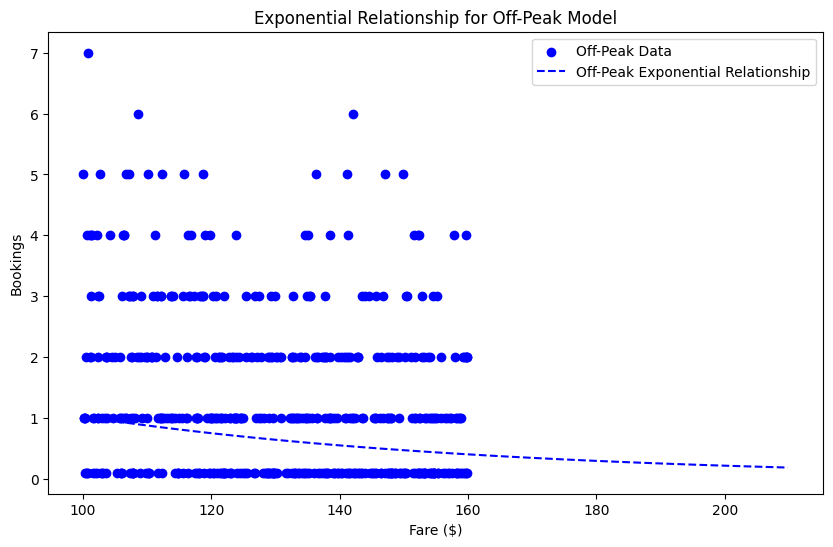

In [218]:
# Create a range of fare values for plotting the exponential relationship
fare_values = np.linspace(demandData['fare'].min(), demandData['fare'].max(), 100)

# Calculate the predicted bookings for the exponential relationship
bookings_off_peak = alpha_off_peak * np.exp(beta_off_peak * fare_values)
bookings_peak = alpha_peak * np.exp(beta_peak * fare_values)

# Plot the original data points and exponential relationship for Off-Peak
plt.figure(figsize=(10, 6))
plt.scatter(off_peak_data['fare'], off_peak_data['bookings'], color='blue', label='Off-Peak Data')
plt.plot(fare_values, bookings_off_peak, color='blue', linestyle='--', label='Off-Peak Exponential Relationship')
plt.xlabel('Fare ($)')
plt.ylabel('Bookings')
plt.title('Exponential Relationship for Off-Peak Model')
plt.legend()
plt.show()

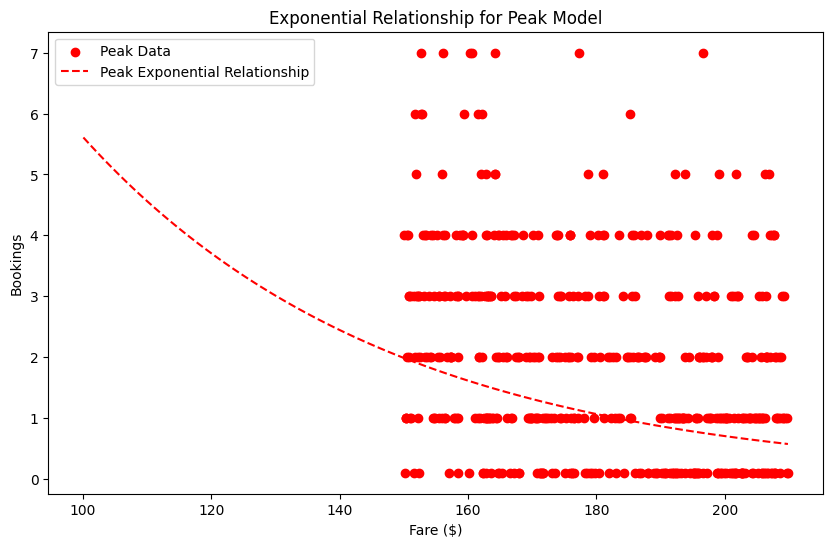

In [219]:
# Plot the original data points and exponential relationship for Peak
plt.figure(figsize=(10, 6))
plt.scatter(peak_data['fare'], peak_data['bookings'], color='red', label='Peak Data')
plt.plot(fare_values, bookings_peak, color='red', linestyle='--', label='Peak Exponential Relationship')
plt.xlabel('Fare ($)')
plt.ylabel('Bookings')
plt.title('Exponential Relationship for Peak Model')
plt.legend()
plt.show()

In [220]:
# Ensure the data only has the 'fare' column
predictData = predictData[['fare']]

# Predict bookings using the off-peak model
predictData['predicted_bookings_off_peak_exp'] = alpha_off_peak * np.exp(beta_off_peak * predictData['fare'])

# Predict bookings using the peak model
predictData['predicted_bookings_peak_exp'] = alpha_peak * np.exp(beta_peak * predictData['fare'])

# # Output the results
print(predictData[["fare", "predicted_bookings_off_peak_exp", "predicted_bookings_peak_exp"]])



    fare  predicted_bookings_off_peak_exp  predicted_bookings_peak_exp
0    220                         0.157944                     0.463113
1    230                         0.135164                     0.376158
2    240                         0.115670                     0.305529
3    250                         0.098988                     0.248162
4    260                         0.084711                     0.201566
5    270                         0.072494                     0.163719
6    280                         0.062038                     0.132979
7    290                         0.053091                     0.108010
8    300                         0.045434                     0.087730
9    310                         0.038881                     0.071258
10   320                         0.033273                     0.057878
11   330                         0.028474                     0.047011
12   340                         0.024368                     0.038184
13   3

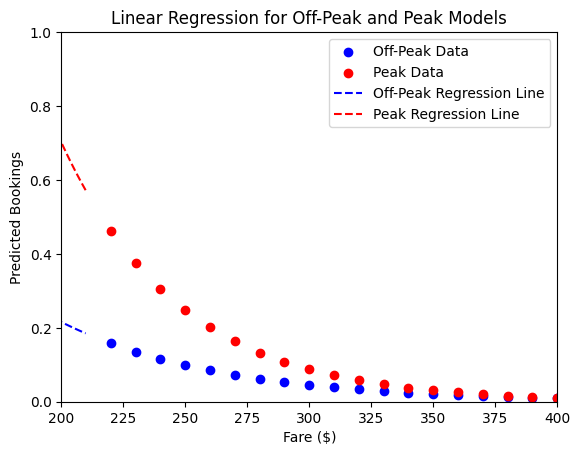

In [221]:
# Plot the original data points
plt.scatter(predictData['fare'], predictData['predicted_bookings_off_peak_exp'], color='blue', label='Off-Peak Data')
plt.scatter(predictData['fare'], predictData['predicted_bookings_peak_exp'], color='red', label='Peak Data')

# Plot the regression lines
plt.plot(fare_values, bookings_off_peak, color='blue', linestyle='--', label='Off-Peak Regression Line')
plt.plot(fare_values, bookings_peak, color='red', linestyle='--', label='Peak Regression Line')

# Add labels and legend
plt.xlabel('Fare ($)')
plt.ylabel('Predicted Bookings')
plt.title('Linear Regression for Off-Peak and Peak Models')
plt.ylim(0, 1)  # Set y-axis limits
plt.xlim(200, 400)  # Set y-axis limits
plt.legend()

In [225]:
demandData['fare_squared'] = demandData['fare'] ** 2


In [226]:
# Separate the data into "Off-Peak" and "Peak"
off_peak_data = demandData[demandData['seasonindex'] == 'Off-Peak']
peak_data = demandData[demandData['seasonindex'] == 'Peak']

# Feature selection
X_off_peak = off_peak_data[['fare', 'fare_squared']]
y_off_peak = off_peak_data['bookings']
X_peak = peak_data[['fare', 'fare_squared']]
y_peak = peak_data['bookings']

In [228]:
# Train the models
model_off_peak = LinearRegression()
model_off_peak.fit(X_off_peak, y_off_peak)

model_peak = LinearRegression()
model_peak.fit(X_peak, y_peak)

# Get the coefficients and intercepts for the off-peak model
alpha_off_peak = model_off_peak.intercept_
beta_off_peak = model_off_peak.coef_[0]
gamma_off_peak = model_off_peak.coef_[1]

# Get the coefficients and intercepts for the peak model
alpha_peak = model_peak.intercept_
beta_peak = model_peak.coef_[0]
gamma_peak = model_peak.coef_[1]

# Print the quadratic relationship parameters
print(f'Off-Peak Model: Bookings = {alpha_off_peak} + {beta_off_peak} * Fare + {gamma_off_peak} * Fare^2')
print(f'Peak Model: Bookings = {alpha_peak} + {beta_peak} * Fare + {gamma_peak} * Fare^2')

r2_off_peak = model_off_peak.score(X_off_peak, y_off_peak)
r2_peak = model_peak.score(X_peak, y_peak)
print(f'R^2 for Off-Peak Model: {r2_off_peak}')
print(f'R^2 for Peak Model: {r2_peak}')




# # Output the results

Off-Peak Model: Bookings = 8.471194356166503 + -0.0956495513970951 * Fare + 0.00030885350764885914 * Fare^2
Peak Model: Bookings = 18.64014691451785 + -0.16157659448724912 * Fare + 0.00037796591016549843 * Fare^2
R^2 for Off-Peak Model: 0.04631332094060647
R^2 for Peak Model: 0.08864035312259388


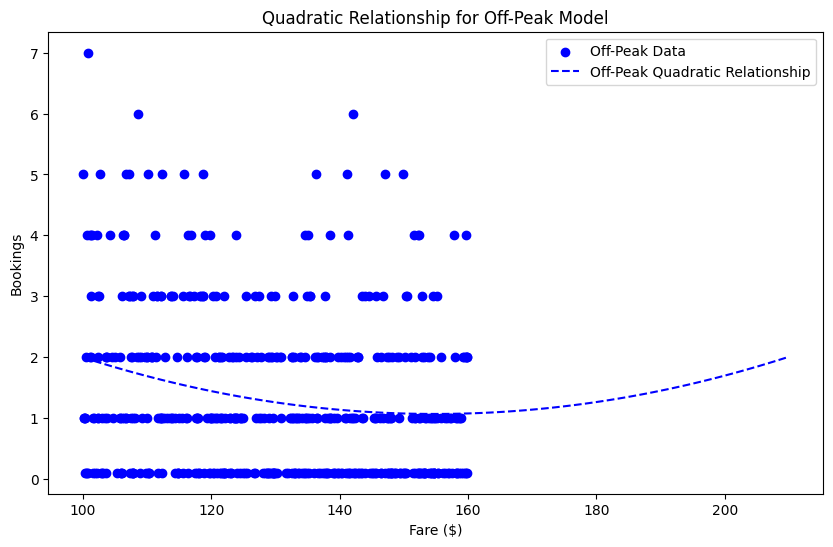

In [229]:
# Create a range of fare values for plotting the quadratic relationship
fare_values = np.linspace(demandData['fare'].min(), demandData['fare'].max(), 100)

# Calculate the predicted bookings for the quadratic relationship
bookings_off_peak = alpha_off_peak + beta_off_peak * fare_values + gamma_off_peak * fare_values ** 2
bookings_peak = alpha_peak + beta_peak * fare_values + gamma_peak * fare_values ** 2





# Plot the original data points and quadratic relationship for Off-Peak
plt.figure(figsize=(10, 6))
plt.scatter(off_peak_data['fare'], off_peak_data['bookings'], color='blue', label='Off-Peak Data')
plt.plot(fare_values, bookings_off_peak, color='blue', linestyle='--', label='Off-Peak Quadratic Relationship')
plt.xlabel('Fare ($)')
plt.ylabel('Bookings')
plt.title('Quadratic Relationship for Off-Peak Model')
plt.legend()
plt.show()

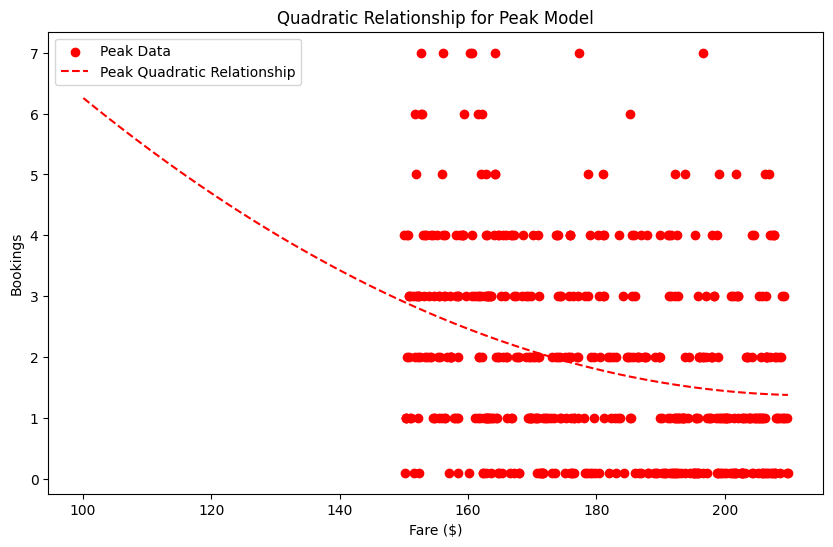

In [230]:
# Plot the original data points and quadratic relationship for Peak
plt.figure(figsize=(10, 6))
plt.scatter(peak_data['fare'], peak_data['bookings'], color='red', label='Peak Data')
plt.plot(fare_values, bookings_peak, color='red', linestyle='--', label='Peak Quadratic Relationship')
plt.xlabel('Fare ($)')
plt.ylabel('Bookings')
plt.title('Quadratic Relationship for Peak Model')
plt.legend()
plt.show()

In [232]:

# Ensure the data only has the 'fare' column
predictData = predictData[['fare']]

# Create quadratic features
predictData['fare_squared'] = predictData['fare'] ** 2

# Predict bookings using the off-peak model
predictData['predicted_bookings_off_peak_exp'] = alpha_off_peak + beta_off_peak * predictData['fare'] + gamma_off_peak * predictData['fare_squared']

# Predict bookings using the peak model
predictData['predicted_bookings_peak_exp'] = alpha_peak + beta_peak * predictData['fare'] + gamma_peak * predictData['fare_squared']
# # Output the results
print(predictData[["fare", "predicted_bookings_off_peak_exp", "predicted_bookings_peak_exp"]])


    fare  predicted_bookings_off_peak_exp  predicted_bookings_peak_exp
0    220                         2.376803                     1.386846
1    230                         2.810148                     1.471927
2    240                         3.305264                     1.632601
3    250                         3.862151                     1.868868
4    260                         4.480808                     2.180728
5    270                         5.161236                     2.568181
6    280                         5.903435                     3.031228
7    290                         6.707404                     3.569868
8    300                         7.573145                     4.184100
9    310                         8.500656                     4.873927
10   320                         9.489937                     5.639346
11   330                        10.540989                     6.480358
12   340                        11.653812                     7.396964
13   3

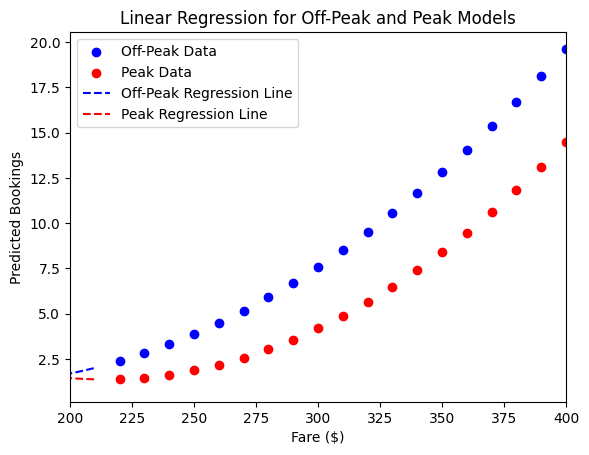

In [233]:
# Plot the original data points
plt.scatter(predictData['fare'], predictData['predicted_bookings_off_peak_exp'], color='blue', label='Off-Peak Data')
plt.scatter(predictData['fare'], predictData['predicted_bookings_peak_exp'], color='red', label='Peak Data')

# Plot the regression lines
plt.plot(fare_values, bookings_off_peak, color='blue', linestyle='--', label='Off-Peak Regression Line')
plt.plot(fare_values, bookings_peak, color='red', linestyle='--', label='Peak Regression Line')

# Add labels and legend
plt.xlabel('Fare ($)')
plt.ylabel('Predicted Bookings')
plt.title('Linear Regression for Off-Peak and Peak Models')
plt.xlim(200, 400)  # Set y-axis limits
plt.legend()

     fare  bookings seasonindex
0  143.88       3.0    Off-Peak
1  167.78       2.0        Peak
2  195.21       0.0        Peak
3  198.84       4.0        Peak
4  134.94       3.0    Off-Peak
              fare     bookings
count  1004.000000  1003.000000
mean    155.056375     1.953141
std      30.881664     5.470552
min     100.080000     0.000000
25%     129.737500     0.000000
50%     154.650000     1.000000
75%     178.992500     3.000000
max     220.000000   110.000000
fare           0
bookings       1
seasonindex    0
dtype: int64


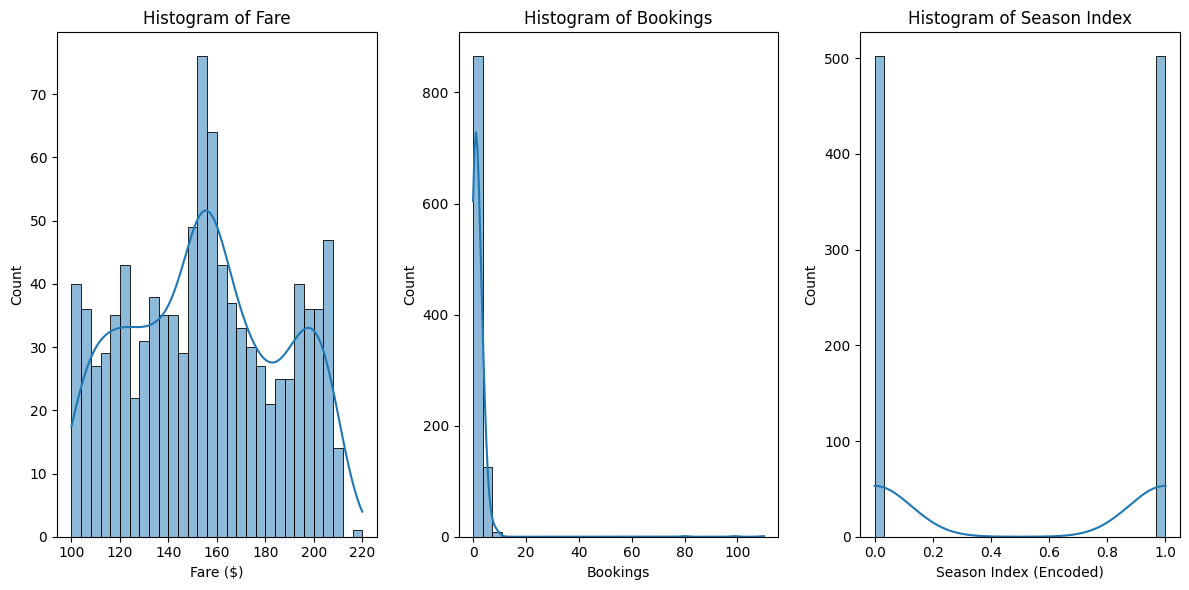

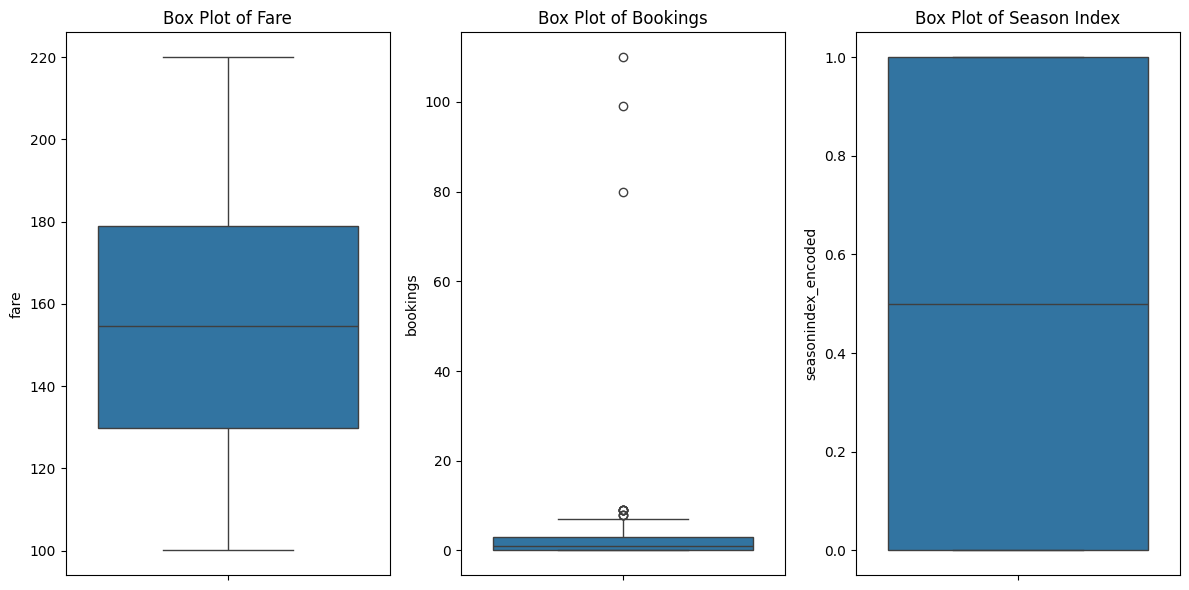

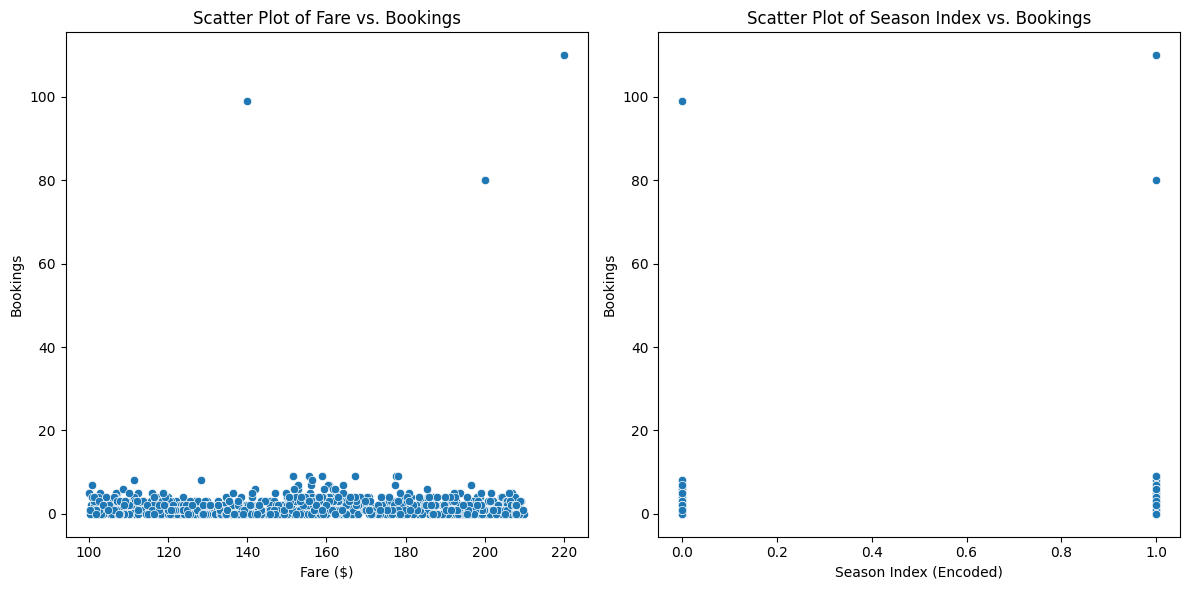

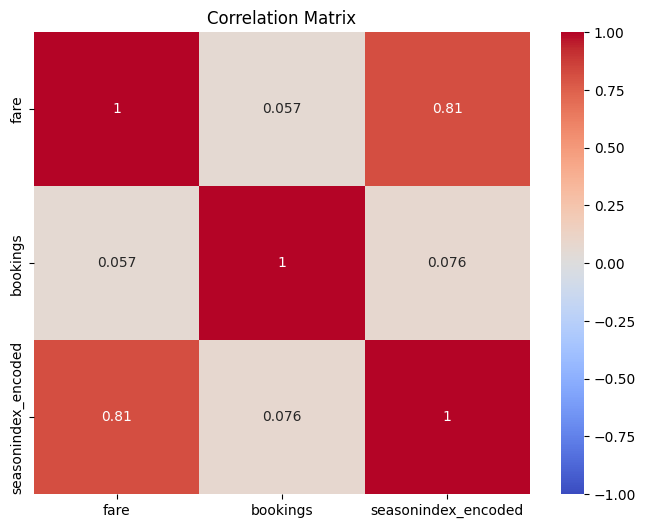

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load the data
demandData = pd.read_csv(demandDataPath)  # Adjust the path as needed

# Display the first few rows of the dataset
print(demandData.head())

# Generate summary statistics for the numerical variables
print(demandData.describe())

# Check for missing values
print(demandData.isnull().sum())

# Encode the 'seasonindex' column
label_encoder = LabelEncoder()
demandData['seasonindex_encoded'] = label_encoder.fit_transform(demandData['seasonindex'])

# Plot histograms for the numerical variables
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(demandData['fare'], bins=30, kde=True)
plt.xlabel('Fare ($)')
plt.title('Histogram of Fare')

plt.subplot(1, 3, 2)
sns.histplot(demandData['bookings'], bins=30, kde=True)
plt.xlabel('Bookings')
plt.title('Histogram of Bookings')

plt.subplot(1, 3, 3)
sns.histplot(demandData['seasonindex_encoded'], bins=30, kde=True)
plt.xlabel('Season Index (Encoded)')
plt.title('Histogram of Season Index')

plt.tight_layout()
plt.show()

# Plot box plots to identify outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(y=demandData['fare'])
plt.title('Box Plot of Fare')

plt.subplot(1, 3, 2)
sns.boxplot(y=demandData['bookings'])
plt.title('Box Plot of Bookings')

plt.subplot(1, 3, 3)
sns.boxplot(y=demandData['seasonindex_encoded'])
plt.title('Box Plot of Season Index')

plt.tight_layout()
plt.show()

# Plot scatter plots to visualize relationships between variables
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=demandData['fare'], y=demandData['bookings'])
plt.xlabel('Fare ($)')
plt.ylabel('Bookings')
plt.title('Scatter Plot of Fare vs. Bookings')

plt.subplot(1, 2, 2)
sns.scatterplot(x=demandData['seasonindex_encoded'], y=demandData['bookings'])
plt.xlabel('Season Index (Encoded)')
plt.ylabel('Bookings')
plt.title('Scatter Plot of Season Index vs. Bookings')

plt.tight_layout()
plt.show()

# Compute and visualize the correlation matrix
correlation_matrix = demandData[['fare', 'bookings', 'seasonindex_encoded']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


In [176]:
# Calculate the mode for each column
print(demandData.mode().iloc[0])


fare                     151.52
bookings                    0.0
seasonindex            Off-Peak
seasonindex_encoded         0.0
Name: 0, dtype: object


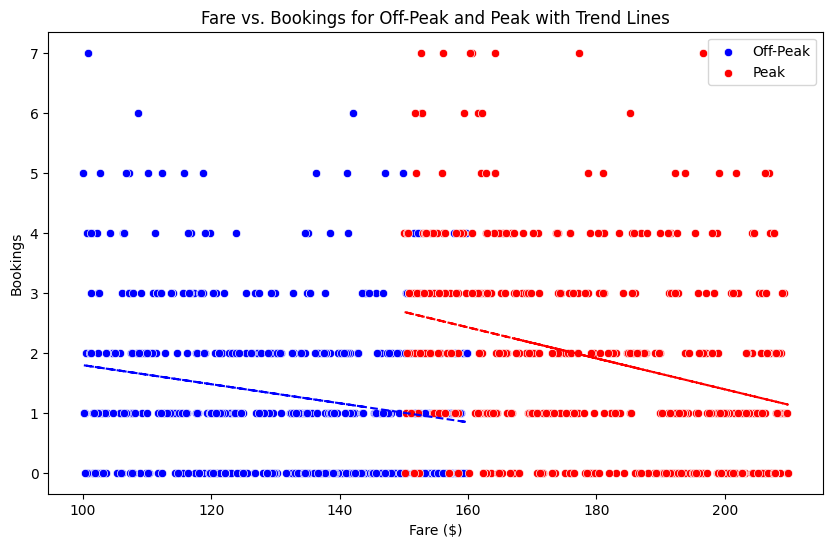

T-statistic: -6.1448100807860335, P-value: 1.1590472660439186e-09


In [180]:
# Separate the data into "Off-Peak" and "Peak"
from scipy.stats import ttest_ind
demandData = demandData.dropna(subset=['bookings'])
# Remove outliers using the IQR method
Q1 = demandData['bookings'].quantile(0.25)
Q3 = demandData['bookings'].quantile(0.75)
IQR = Q3 - Q1
filter = (demandData['bookings'] >= Q1 - 1.5 * IQR) & (demandData['bookings'] <= Q3 + 1.5 * IQR)
demandData = demandData.loc[filter]

off_peak_data = demandData[demandData['seasonindex'] == 'Off-Peak']
peak_data = demandData[demandData['seasonindex'] == 'Peak']

# Plot fare vs. bookings for "Off-Peak" and "Peak" on the same figure with trend lines
plt.figure(figsize=(10, 6))
sns.scatterplot(x=off_peak_data['fare'], y=off_peak_data['bookings'], color='blue', label='Off-Peak')
sns.scatterplot(x=peak_data['fare'], y=peak_data['bookings'], color='red', label='Peak')

# Add trend line for Off-Peak
off_peak_model = LinearRegression()
off_peak_model.fit(off_peak_data[['fare']], off_peak_data['bookings'])
off_peak_trend = off_peak_model.predict(off_peak_data[['fare']])
plt.plot(off_peak_data['fare'], off_peak_trend, color='blue', linestyle='--')

# Add trend line for Peak
peak_model = LinearRegression()
peak_model.fit(peak_data[['fare']], peak_data['bookings'])
peak_trend = peak_model.predict(peak_data[['fare']])
plt.plot(peak_data['fare'], peak_trend, color='red', linestyle='--')

plt.xlabel('Fare ($)')
plt.ylabel('Bookings')
plt.title('Fare vs. Bookings for Off-Peak and Peak with Trend Lines')
plt.legend()
plt.show()

# Perform an independent t-test
t_stat, p_value = ttest_ind(off_peak_data['bookings'], peak_data['bookings'])
print(f'T-statistic: {t_stat}, P-value: {p_value}')